Evaluation of SVR and gradient boosting regression on steel dataset

In [1]:

#Data prepocessing
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold, cross_validate, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

# Load dataset
df = pd.read_csv("steel.csv")

X = df.drop("tensile_strength", axis=1)
y = df["tensile_strength"]

rmse = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)))
r2 = make_scorer(r2_score)




Gradient Boosting Regressor

In [2]:
# 10-fold cross-validation (default hyperparameters)
model = GradientBoostingRegressor()

cv = KFold(n_splits=10, shuffle=True, random_state=67)

cv_results = cross_validate(
    model,
    X, y,
    cv=cv,
    scoring={'RMSE': rmse, 'R2': r2},
    return_train_score=True
)

print("=== Default Hyperparameters ===")
print("Average Train RMSE:", np.mean(cv_results['train_RMSE']))
print("Average Test RMSE:", np.mean(cv_results['test_RMSE']))
print("Average Train R2:", np.mean(cv_results['train_R2']))
print("Average Test R2:", np.mean(cv_results['test_R2']))

=== Default Hyperparameters ===
Average Train RMSE: 16.970744348206555
Average Test RMSE: 28.375276564765464
Average Train R2: 0.9652491804618029
Average Test R2: 0.8999030318020258


In [3]:
#Gradient Boosting optimisation for RMSE
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 300, 500]
}

tuned_model = GridSearchCV(
    estimator=GradientBoostingRegressor(),
    param_grid=param_grid,
    scoring=['neg_mean_squared_error', 'r2'], 
    refit='neg_mean_squared_error',  
    cv=cv,
    n_jobs=-1
)

tuned_model.fit(X, y)

print("\n------ Best Hyperparameters ------")
print(tuned_model.best_params_)

# ---------------------------
# Evaluate tuned model
# ---------------------------
best_model = tuned_model.best_estimator_

tuned_results = cross_validate(
    best_model,
    X, y,
    cv=cv,
    scoring={'RMSE': rmse, 'R2': r2},
    return_train_score=True
)

print("\n------ Tuned Hyperparameter Results ------")
print("Train RMSE:", np.mean(tuned_results['train_RMSE']))
print("Test RMSE :", np.mean(tuned_results['test_RMSE']))
print("Train R²  :", np.mean(tuned_results['train_R2']))
print("Test R²   :", np.mean(tuned_results['test_R2']))


------ Best Hyperparameters ------
{'learning_rate': 0.1, 'n_estimators': 500}

------ Tuned Hyperparameter Results ------
Train RMSE: 5.843602097555783
Test RMSE : 26.05527691299012
Train R²  : 0.9958762699010937
Test R²   : 0.9160148577957752

------ Tuned Hyperparameter Results ------
Train RMSE: 5.843602097555783
Test RMSE : 26.05527691299012
Train R²  : 0.9958762699010937
Test R²   : 0.9160148577957752


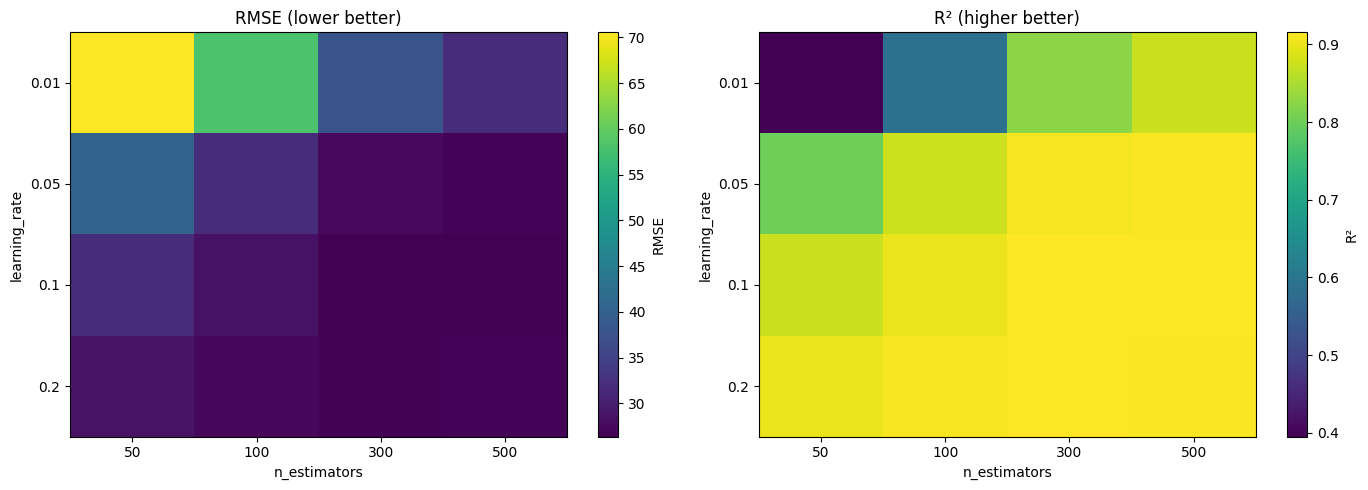

In [ ]:
##Heatmap for best gradient boosting values for RMSE and R^2
import matplotlib.pyplot as plt

results = pd.DataFrame(tuned_model.cv_results_)


# Calculate RMSE from mean_test_neg_mean_squared_error
results['RMSE'] = np.sqrt(-results['mean_test_neg_mean_squared_error'])
heatmap_rmse = results.pivot(index='param_learning_rate', columns='param_n_estimators', values='RMSE')
heatmap_r2   = results.pivot(index='param_learning_rate', columns='param_n_estimators', values='mean_test_r2')



fig, axes = plt.subplots(1, 2, figsize=(14, 5))

im0 = axes[0].imshow(heatmap_rmse, cmap='viridis', aspect='auto')
axes[0].set_title('RMSE (lower better)')
axes[0].set_xlabel('n_estimators')
axes[0].set_ylabel('learning_rate')
axes[0].set_xticks(range(len(heatmap_rmse.columns))); axes[0].set_xticklabels(heatmap_rmse.columns)
axes[0].set_yticks(range(len(heatmap_rmse.index)));  axes[0].set_yticklabels(heatmap_rmse.index)
fig.colorbar(im0, ax=axes[0], label='RMSE')

im1 = axes[1].imshow(heatmap_r2, cmap='viridis', aspect='auto')
axes[1].set_title('R² (higher better)')
axes[1].set_xlabel('n_estimators')
axes[1].set_ylabel('learning_rate')
axes[1].set_xticks(range(len(heatmap_r2.columns))); axes[1].set_xticklabels(heatmap_r2.columns)
axes[1].set_yticks(range(len(heatmap_r2.index)));  axes[1].set_yticklabels(heatmap_r2.index)
fig.colorbar(im1, ax=axes[1], label='R²')

plt.tight_layout()
plt.show()

Support Vector Regression 

In [ ]:
# 10-fold cross validation (default hyperparameters)
# ---------------------------
model = SVR()

cv = KFold(n_splits=10, shuffle=True, random_state=67)

cv_results = cross_validate(
    model,
    X, y,
    cv=cv, 
    scoring={'RMSE': rmse, 'R2': r2},
    return_train_score=True
)

print("=== Default Hyperparameters (SVR) ===")
print("Average Train RMSE:", np.mean(cv_results['train_RMSE']))
print("Average Test RMSE:", np.mean(cv_results['test_RMSE']))
print("Average Train R² :", np.mean(cv_results['train_R2']))
print("Average Test R²  :", np.mean(cv_results['test_R2']))

=== Default Hyperparameters (SVR) ===
Average Train RMSE: 77.6674876079019
Average Test RMSE: 77.58494930192272
Average Train R² : 0.2722286521991325
Average Test R²  : 0.26627674849218774


In [6]:

# SVR hyperparameter tuning
# ---------------------------
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],          # regularization strength
    'epsilon': [0.1, 1, 5, 10, 20]         # ε-insensitive tube width
}

tuned_model = GridSearchCV(
    estimator=SVR(kernel="rbf"),           # RBF as common strong baseline
    param_grid=param_grid,
    scoring=['neg_mean_squared_error', 'r2'],
    refit='neg_mean_squared_error',        # choose best model based on MSE
    cv=cv,
    n_jobs=-1
)

tuned_model.fit(X, y)

print("\n------ Best Hyperparameters (SVR) ------")
print(tuned_model.best_params_)

# ---------------------------
# Evaluate tuned SVR model
# ---------------------------
best_model = tuned_model.best_estimator_

tuned_results = cross_validate(
    best_model,
    X, y,
    cv=cv,
    scoring={'RMSE': rmse, 'R2': r2},
    return_train_score=True
)

print("\n=== Tuned SVR Results ===")
print("Average Train RMSE:", np.mean(tuned_results['train_RMSE']))
print("Average Test RMSE :", np.mean(tuned_results['test_RMSE']))
print("Average Train R² :", np.mean(tuned_results['train_R2']))
print("Average Test R²  :", np.mean(tuned_results['test_R2']))


------ Best Hyperparameters (SVR) ------
{'C': 1000, 'epsilon': 5}

=== Tuned SVR Results ===
Average Train RMSE: 60.49656207923213
Average Test RMSE : 61.23719888998626
Average Train R² : 0.5583964412519193
Average Test R²  : 0.5358087603415599

=== Tuned SVR Results ===
Average Train RMSE: 60.49656207923213
Average Test RMSE : 61.23719888998626
Average Train R² : 0.5583964412519193
Average Test R²  : 0.5358087603415599


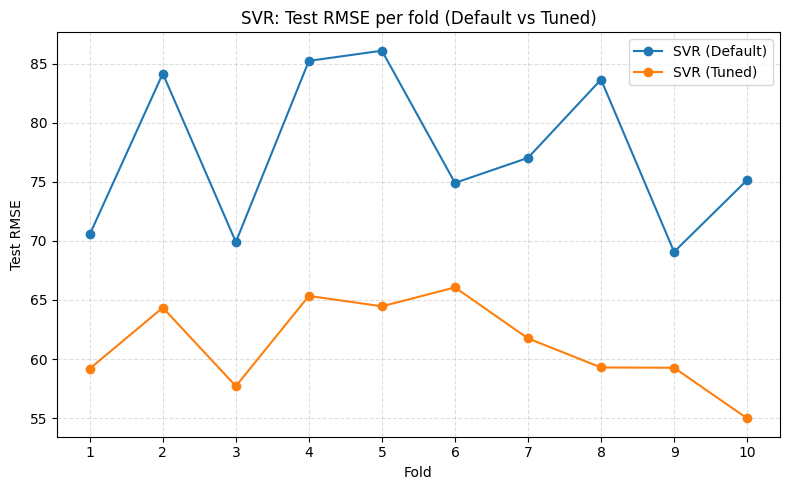

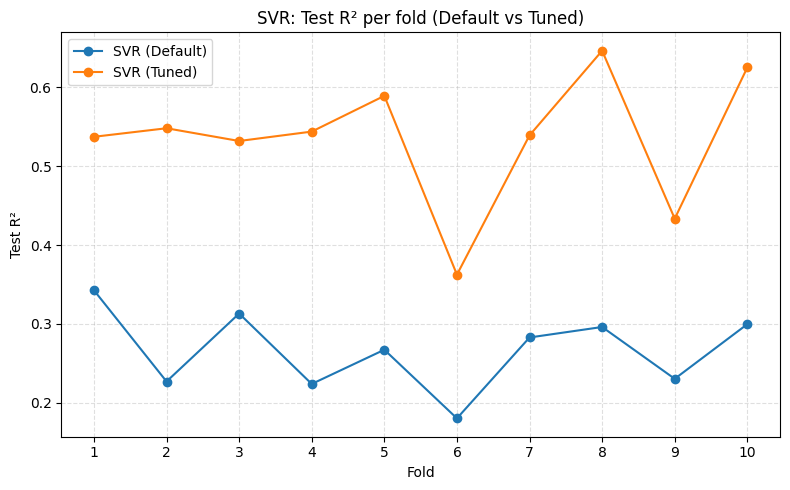

In [ ]:
#Create graph comparing tuned and default SVR model over 10 folds

n_folds = len(cv_results['test_RMSE'])
folds = np.arange(1, n_folds + 1)

#
svr_per_fold = pd.DataFrame({
    'Fold': np.concatenate([folds, folds]),
    'Model': ['SVR (Default)'] * n_folds + ['SVR (Tuned)'] * n_folds,
    'Test_RMSE': np.concatenate([cv_results['test_RMSE'], tuned_results['test_RMSE']]),
    'Test_R2': np.concatenate([cv_results['test_R2'], tuned_results['test_R2']])
})


svr_per_fold = svr_per_fold.sort_values(['Fold', 'Model'])



plt.figure(figsize=(8, 5))
for model_name, group in svr_per_fold.groupby('Model'):
    plt.plot(group['Fold'], group['Test_RMSE'], marker='o', label=model_name)

plt.xlabel('Fold')
plt.ylabel('Test RMSE')
plt.title('SVR: Test RMSE per fold (Default vs Tuned)')
plt.xticks(folds)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# Optional: line plot for Test R² as well
plt.figure(figsize=(8, 5))
for model_name, group in svr_per_fold.groupby('Model'):
    plt.plot(group['Fold'], group['Test_R2'], marker='o', label=model_name)

plt.xlabel('Fold')
plt.ylabel('Test R²')
plt.title('SVR: Test R² per fold (Default vs Tuned)')
plt.xticks(folds)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()